In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import joblib

In [17]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [18]:
cols_to_drop= ['Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)

Топ-10 наиболее важных дескрипторов для SI:
VSA_EState6            0.436736
VSA_EState2            0.072989
MinPartialCharge       0.046453
qed                    0.042467
BalabanJ               0.039384
MaxAbsPartialCharge    0.033763
VSA_EState9            0.013653
VSA_EState8            0.013173
FractionCSP3           0.013069
MaxAbsEStateIndex      0.009237
dtype: float64


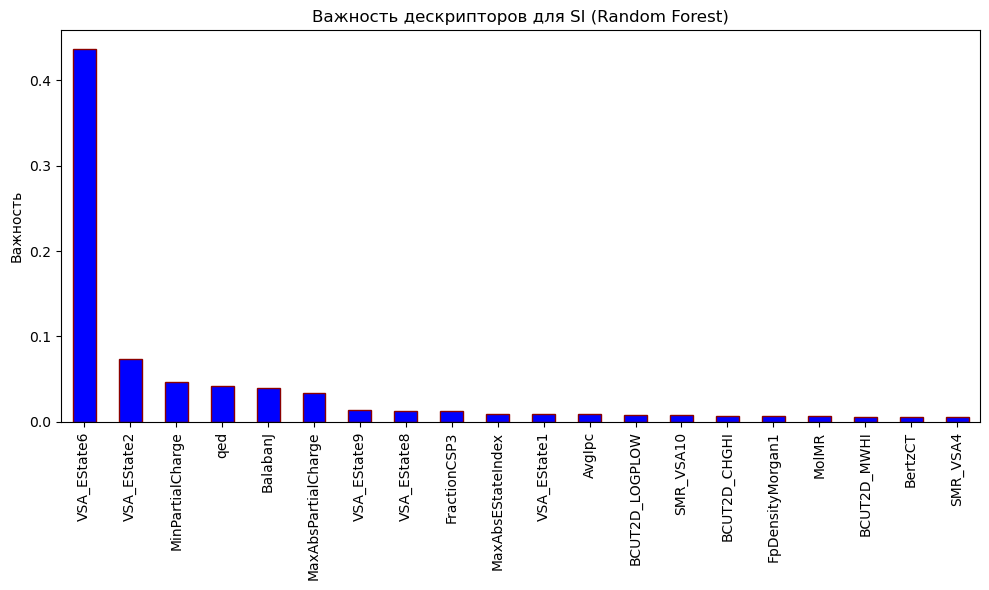

In [13]:
# Константы для удобства
TARGET_SI = 'SI'
DROP_COLS_SI = [TARGET_SI, 'IC50, mM', 'CC50, mM']
TOP_FEATURES = 10
PLOT_FEATURES = 20
BAR_COLOR = 'blue'  

# Подготовка данных
X_si = df.drop(DROP_COLS_SI, axis=1)
y_si = df[TARGET_SI]

# Разделение данных
X_train_si, X_test_si, y_train_si, y_test_si = train_test_split(
    X_si, y_si, 
    test_size=0.2, 
    random_state=42
)

# Обучение модели
model_si = RandomForestRegressor(n_estimators=100, random_state=42)
model_si.fit(X_train_si, y_train_si)

# Анализ важности признаков
feature_importances_si = (
    pd.Series(model_si.feature_importances_, index=X_si.columns)
    .sort_values(ascending=False)
)

# Вывод результатов
print(f"Топ-{TOP_FEATURES} наиболее важных дескрипторов для {TARGET_SI}:")
print(feature_importances_si.head(TOP_FEATURES))

# Визуализация
plt.figure(figsize=(10, 6))
feature_importances_si.head(PLOT_FEATURES).plot(
    kind='bar', 
    color=BAR_COLOR,
    edgecolor='darkred'  
)
plt.title(f'Важность дескрипторов для {TARGET_SI} (Random Forest)')
plt.ylabel('Важность')
plt.tight_layout()  
plt.show()

In [19]:
# удалим данные для дальнейшей обработки
cols_to_drop= ['CC50, mM', 'IC50, mM']
df = df.drop(cols_to_drop, axis=1)

#### Сделаем оптимизацию выбросов

In [20]:
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

# Рассчитываем медиану и межквартильный размах для фильтрации выбросов
median_cc50 = df['SI'].median()
q1 = df['SI'].quantile(0.25)
q3 = df['SI'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Фильтрация выбросов
df = df[(df['SI'] >= lower_bound) & (df['SI'] <= upper_bound)].copy()
filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")

Исходное количество записей: 1001
Количество записей после удаления выбросов: 876
Удалено записей: 125


### Инжиниринг признаков

In [21]:
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered),
                               columns=df_engineered.columns)

### Определение моделей и функции оценки

In [22]:
# Словарь моделей
regression_models = {
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Stacking': StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', XGBRegressor(random_state=42))
        ],
        final_estimator=LinearRegression()
    )
}

def evaluate_model(name, model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, model

# Оценка всех моделей
evaluation_results = []
best_model = None
best_r2 = -np.inf
best_model_name = ''

for name, model in tqdm(regression_models.items(), desc="Оценка моделей"):
    metrics, trained_model = evaluate_model(name, model, df_engineered, y)
    evaluation_results.append(metrics)

    if metrics['R2'] > best_r2:
        best_r2 = metrics['R2']
        best_model = trained_model
        best_model_name = name

# Вывод результатов
results_df = pd.DataFrame(evaluation_results).sort_values(by="R2", ascending=False)
print("Результаты моделей:")
print(results_df)

print(f"\nЛучшая модель: {best_model_name} (R2 = {best_r2:.4f})")

Оценка моделей: 100%|████████████████████████████████████████████████████████████████████| 8/8 [01:06<00:00,  8.27s/it]

Результаты моделей:
                  Model        MSE      RMSE        R2
7              Stacking  62.554337  7.909130  0.136220
2     Gradient Boosting  65.755384  8.108969  0.092018
1         Random Forest  70.480997  8.395296  0.026765
6              CatBoost  70.506990  8.396844  0.026406
3  HistGradientBoosting  70.633541  8.404376  0.024659
4              AdaBoost  77.478306  8.802176 -0.069857
5               XGBoost  80.282142  8.960030 -0.108574
0                   KNN  91.367022  9.558610 -0.261639

Лучшая модель: Stacking (R2 = 0.1362)


### Визуализируем

C:\Users\NikLeo\AppData\Local\Temp\ipykernel_6764\3815027730.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')


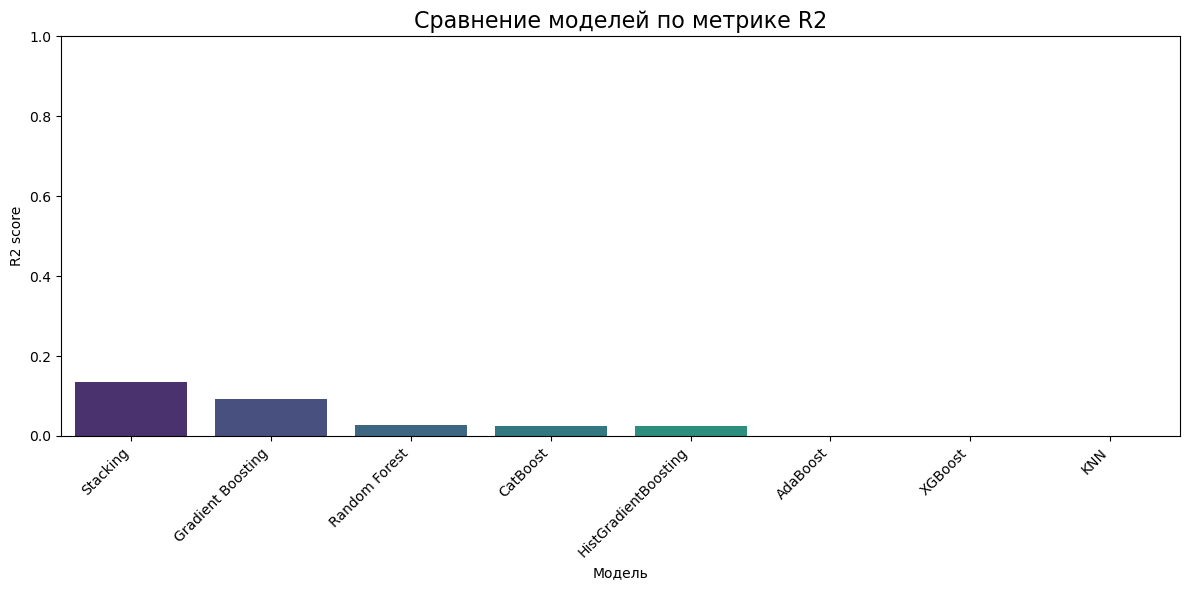


Результаты моделей (таргет: CC50, mM):


,Model,MSE,RMSE,R2
7,Stacking,62.554,7.909,0.136
2,Gradient Boosting,65.755,8.109,0.092
1,Random Forest,70.481,8.395,0.027
6,CatBoost,70.507,8.397,0.026
3,HistGradientBoosting,70.634,8.404,0.025
4,AdaBoost,77.478,8.802,-0.070
5,XGBoost,80.282,8.960,-0.109
0,KNN,91.367,9.559,-0.262


In [23]:
from IPython.display import display

# Сортировка и округление результатов
results_df = pd.DataFrame(evaluation_results).sort_values(by='R2', ascending=False).round(3)

# Функция отображения графика сравнения моделей
def plot_model_comparison(df, metric='R2'):
    sorted_df = df.sort_values(by=metric, ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, data=sorted_df, palette='viridis')
    plt.title(f'Сравнение моделей по метрике {metric}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    if metric == 'R2':
        plt.ylim(0, 1)
    plt.ylabel(f'{metric} score')
    plt.xlabel('Модель')
    plt.tight_layout()
    plt.show()

plot_model_comparison(results_df)

# Функция красивого отображения таблицы
def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [
            ('background-color', '#40466e'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f5f5f5')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'white')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]}
    ]

    return (df.style
              .set_table_styles(styles)
              .format({'MSE': '{:,.3f}', 'RMSE': '{:,.3f}', 'R2': '{:,.3f}'})
              .highlight_max(subset=['R2'], color='#90EE90')
              .highlight_min(subset=['R2'], color='#FFCCCB'))

print("\nРезультаты моделей (таргет: CC50, mM):")
display(display_beautiful_table(results_df))

Лучшее качество среди протестированных моделей показал ансамбль Stacking, достигнув минимальной ошибки (MSE = 62.554, RMSE ≈ 7.91) и наивысшего R² = 0.136. Несмотря на то, что абсолютное значение R² остаётся низким (лишь 13.6% объяснённой дисперсии), Stacking оказался единственным подходом, обеспечившим хоть сколько-нибудь выраженное преимущество по сравнению с остальными. Это может указывать на то, что комбинирование слабых моделей позволяет компенсировать их индивидуальные недостатки.

Gradient Boosting занял второе место, с немного худшими показателями (R² = 0.092), подтвердив свою устойчивость в задачах с ограниченной структурой или сложными закономерностями. Тем не менее, значение R² всё ещё довольно низкое, что говорит о слабом соответствии модели реальным данным.

Модели Random Forest, CatBoost и HistGradientBoosting показали практически идентичные и весьма скромные результаты (R² ≈ 0.025–0.027). Хотя они часто демонстрируют высокую эффективность на табличных данных, в данном случае их возможности ограничены — возможно, из-за шумности данных, недостатка признаков или отсутствия выраженных паттернов.

AdaBoost и XGBoost показали отрицательные значения R², что означает, что они предсказывают хуже, чем простая средняя по таргету. Это говорит о существенной несостоятельности этих моделей в текущей постановке задачи.

KNN в очередной раз продемонстрировал худшее качество: R² = -0.262, а ошибка (RMSE = 9.56) самая высокая среди всех моделей. Это подтверждает, что KNN абсолютно не подходит для данной задачи и не способен адекватно моделировать зависимость между признаками и целевой переменной.